In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import faiss
import numpy as np
import matplotlib.pyplot as plt

print("Initializing ViT Embedding Model and Vector Database...")

# 1. Load a pre-trained ViT-Base (Patch 16) model
embedding_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# ViT's classification head is stored in 'model.heads'.
# We replace it with an Identity layer to extract the raw 768-dimensional CLS token embeddings.
embedding_model.heads = nn.Identity()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = embedding_model.to(device)
embedding_model.eval()

# 2. Extract Embeddings for the entire test set
all_embeddings = []
all_labels = []
all_images = []

print("Extracting visual embeddings from the test set...")
with torch.no_grad():
    for inputs, targets in test_loader:
        # Save original images for the visualizer
        for img in inputs:
            img_unnorm = img.numpy() * 0.5 + 0.5 # un-normalize

            # --- FIX: Transpose for matplotlib ---
            # DataLoader outputs [3, 224, 224] (PyTorch CHW format).
            # We transpose to [224, 224, 3] (HWC format) so Cell 10 can plot it!
            img_vis = np.transpose(img_unnorm, (1, 2, 0))
            img_vis = np.clip(img_vis, 0, 1) # Ensure valid pixel range
            all_images.append(img_vis)

        inputs = inputs.to(device)

        # --- FIX: Feed directly to ViT ---
        # Because your test_loader is ALREADY resizing to 224x224 and outputting 3 channels,
        # we don't need to manually repeat or interpolate here. Just pass it in!
        embeddings = embedding_model(inputs)

        # Move to CPU and convert to numpy for FAISS
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.extend(targets.cpu().numpy().flatten())

# Flatten the batches into a single large array
all_embeddings = np.vstack(all_embeddings).astype('float32')
all_labels = np.array(all_labels)

# 3. Build the FAISS Vector Index
embedding_dimension = all_embeddings.shape[1] # This will output 768 for ViT-B/16
index = faiss.IndexFlatL2(embedding_dimension)
index.add(all_embeddings)

print(f"FAISS Index built successfully!")
print(f"Total images in database: {index.ntotal}")
print(f"Embedding dimension: {embedding_dimension}")

Initializing ViT Embedding Model and Vector Database...
Extracting visual embeddings from the test set...
FAISS Index built successfully!
Total images in database: 624
Embedding dimension: 768


Evaluating Retrieval System (Precision@5)...
Overall Mean Precision@5: 0.8321

Visualizing a Normal query example:


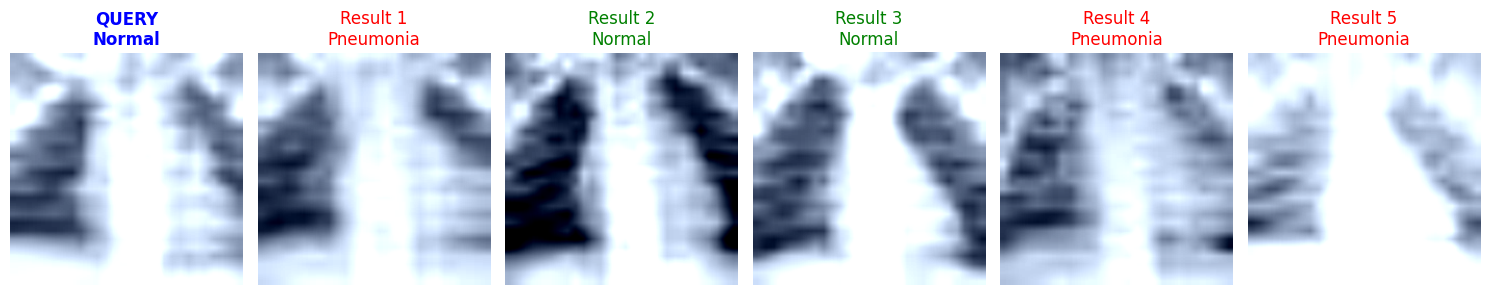

Visualizing a Pneumonia query example:


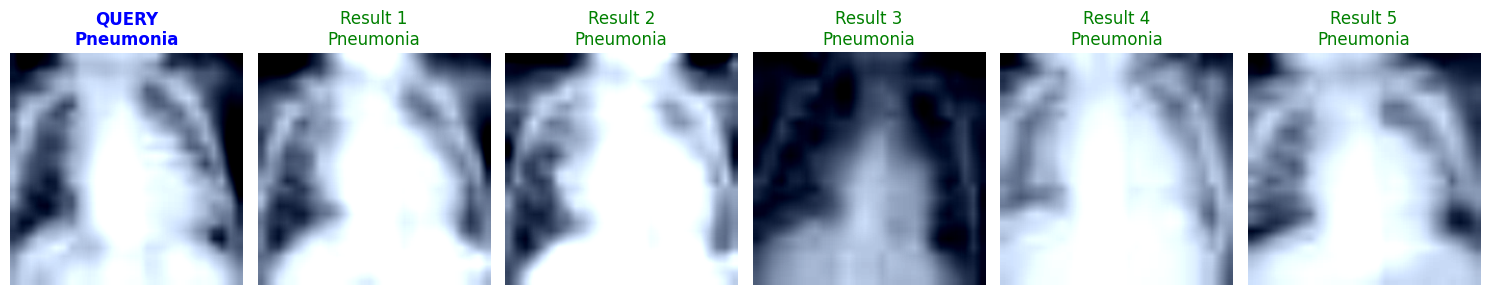

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We want to retrieve the top 5 most similar images
k = 5

print(f"Evaluating Retrieval System (Precision@{k})...")

# 1. Search the FAISS index for all test images at once
# We ask for k+1 because the query image itself is in the database
distances, indices = index.search(all_embeddings, k + 1)

total_precision = 0.0

# 2. Calculate Precision@k for every single image in the test set
for i in range(len(all_labels)):
    query_label = all_labels[i]

    # Drop the first result (index 0) because it is the query image itself
    retrieved_indices = indices[i][1:]
    retrieved_labels = all_labels[retrieved_indices]

    # How many of the top-k retrieved images have the exact same label as the query?
    matches = np.sum(retrieved_labels == query_label)
    precision = matches / k
    total_precision += precision

# 3. Compute the mean Precision@k across the entire dataset
mean_precision_at_k = total_precision / len(all_labels)

print(f"Overall Mean Precision@{k}: {mean_precision_at_k:.4f}")

# ==========================================
# Visualization of Retrieval Results
# ==========================================
def visualize_retrieval(query_idx, k=5):
    query_img = all_images[query_idx]
    query_label = all_labels[query_idx]

    # Drop the self-match
    retrieved_idx_list = indices[query_idx][1:k+1]

    fig, axes = plt.subplots(1, k + 1, figsize=(15, 3))
    label_map = {0: "Normal", 1: "Pneumonia"}

    # Plot the Query Image
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title(f"QUERY\n{label_map[query_label]}", color='blue', fontweight='bold')
    axes[0].axis('off')

    # Plot the Top-K Results
    for j, ret_idx in enumerate(retrieved_idx_list):
        ret_img = all_images[ret_idx]
        ret_label = all_labels[ret_idx]

        axes[j+1].imshow(ret_img, cmap='gray')

        # Color the title green if it's a correct match, red if incorrect
        color = 'green' if ret_label == query_label else 'red'
        axes[j+1].set_title(f"Result {j+1}\n{label_map[ret_label]}", color=color)
        axes[j+1].axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing a Normal query example:")
# Find the index of the first Normal (0) image in the test set
first_normal_idx = np.where(all_labels == 0)[0][0]
visualize_retrieval(first_normal_idx)

print("Visualizing a Pneumonia query example:")
# Find the index of the first Pneumonia (1) image in the test set
first_pneumonia_idx = np.where(all_labels == 1)[0][0]
visualize_retrieval(first_pneumonia_idx)